In [54]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer,DataCollatorWithPadding
from transformers import AdamW, get_scheduler
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import numpy as np

# import evaluate


In [20]:
# Load dataset
data_files = {"train": "/Users/jianhongxu/python_project/twitter_dataset/data/train_dataset_85k.csv",
               "test": "/Users/jianhongxu/python_project/twitter_dataset/data/test_dataset_85k.csv"}
raw_datasets = load_dataset("csv",data_files=data_files)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['tweet', 'class'],
        num_rows: 68306
    })
    test: Dataset({
        features: ['tweet', 'class'],
        num_rows: 17077
    })
})

In [21]:
raw_datasets['train'][0]

{'tweet': 'marked as toread have you seen me by kate white httpurl',
 'class': 'ADHD'}

# convert string class to numerical labels

In [22]:
unique_labels = list(set(raw_datasets['train']['class']))
unique_labels

['ADHD', 'BIPOLAR', 'DEPRESSION']

In [23]:
from datasets import ClassLabel
raw_datasets = raw_datasets.rename_column("class","labels")
raw_datasets = raw_datasets.cast_column('labels',ClassLabel(names=unique_labels))
raw_datasets['train'][0]

{'tweet': 'marked as toread have you seen me by kate white httpurl',
 'labels': 0}

In [24]:
raw_datasets['train'].features

{'tweet': Value(dtype='string', id=None),
 'labels': ClassLabel(names=['ADHD', 'BIPOLAR', 'DEPRESSION'], id=None)}

In [25]:
# checkpoint = '/root/autodl-tmp/cache'
checkpoint = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example['tweet'], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_datasets

/Users/jianhongxu/Library/Python/3.9/lib/python/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/68306 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tweet', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 68306
    })
    test: Dataset({
        features: ['tweet', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 17077
    })
})

## There is an example for Roberta tokenizer

In [9]:
text = "how are you"
print("text: ", text)
tokenized_text = tokenizer(text, truncation=True)
print("input ids :", tokenized_text['input_ids'])
print('attention_mask :',tokenized_text['attention_mask'] )
tokens_text = tokenizer.convert_ids_to_tokens(tokenized_text['input_ids'])
print("convert ids to token: ", tokens_text)
clean_tokens = [token.lstrip('Ġ') for token in tokens_text]
print("cleaned tokens:",clean_tokens)

text:  how are you
input ids : [0, 9178, 32, 47, 2]
attention_mask : [1, 1, 1, 1, 1]
convert ids to token:  ['<s>', 'how', 'Ġare', 'Ġyou', '</s>']
cleaned tokens: ['<s>', 'how', 'are', 'you', '</s>']


- Some words have Ġ prefix becasuse they are preceded by a space in the input.
- These are special tokens indicating the start (< s >) and end (< /s >) of a sentence. They are added by default with add_special_tokens=True. (they are 0 and 2 in input_ids)


## this is an example from datasets

In [26]:
print(tokenized_datasets['train'][0]['tweet'])
input_ids = tokenized_datasets['train'][0]['input_ids']
print(input_ids)
print(tokenized_datasets['train'][0]['attention_mask'])
decode_token = tokenizer.convert_ids_to_tokens(input_ids)
print(decode_token)

marked as toread have you seen me by kate white httpurl
[0, 18584, 25, 7, 12745, 33, 47, 450, 162, 30, 449, 877, 1104, 2054, 6423, 2]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['<s>', 'marked', 'Ġas', 'Ġto', 'read', 'Ġhave', 'Ġyou', 'Ġseen', 'Ġme', 'Ġby', 'Ġk', 'ate', 'Ġwhite', 'Ġhttp', 'url', '</s>']


In [27]:
tokenized_datasets = tokenized_datasets.remove_columns(['tweet'])
tokenized_datasets.set_format('torch')
tokenized_datasets['train'].column_names

['labels', 'input_ids', 'attention_mask']

In [42]:

test_dataloader = DataLoader(
    tokenized_datasets['test'], batch_size=8, collate_fn=data_collator
)

In [ ]:
# for batch in train_dataloader:
#     break
# {k:v.shape for k, v in batch.items()}

{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 52]),
 'attention_mask': torch.Size([8, 52])}

In [17]:
model = RobertaForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# ouput = model(**batch)
# print(ouput.loss, ouput.logits.shape)

tensor(1.1218, grad_fn=<NllLossBackward0>) torch.Size([8, 3])


In [44]:
optimizer = AdamW(model.parameters(), lr=1e-5,weight_decay=0.01)
print(optimizer)

AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    lr: 1e-05
    weight_decay: 0.01
)


/Users/jianhongxu/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
device

device(type='cpu')

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_train_losses = []
fold_train_accuracies = []
fold_val_losses = []
fold_val_accuracies = []

for fold, (train_index, val_index) in enumerate(kf.split(range(len(tokenized_datasets['train'])))):
    print(f"\nFold {fold + 1}/5")
    train_dataset = tokenized_datasets['train'].select(train_index)
    val_dataset = tokenized_datasets['train'].select(val_index)

    train_dataloader = DataLoader(
        train_dataset,shuffle=True, batch_size=8, collate_fn=data_collator
    )
    eval_dataloader = DataLoader(
        val_dataset, batch_size=8, collate_fn=data_collator
    )

    num_epochs = 2

    num_training_steps = num_epochs * len(train_dataloader)

    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )   
    print(f"number training  steps:{num_training_steps}")

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        progress_bar = tqdm(range(len(train_dataloader)), desc=f"[epoch{epoch+1}/epochs{num_epochs}]")
        model.train()
        train_total_loss = 0
        train_correct = 0
        train_total = 0
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits
            
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
     

            train_total_loss +=loss.item()

            preds = torch.argmax(logits, dim=-1)
            train_correct += torch.sum(preds == batch["labels"]).cpu()

            train_total +=batch["labels"].size(0)
            progress_bar.set_postfix({'train_loss': f'{loss.item():.4f}', 'train_accuracy': f'{train_correct/train_total:.4f}'})
            progress_bar.update(1)
    
        train_avg_loss = train_total_loss / len(train_dataloader)
        train_avg_accuracy = train_correct / train_total
        train_losses.append(train_avg_loss)
        train_accuracies.append(train_avg_accuracy)


        model.eval()
        eval_total_loss = 0
        eval_correct_predictions = 0
        eval_total = 0

        with torch.no_grad():
            for batch in eval_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                logits = outputs.logits

                eval_total_loss += loss.item()
                preds = torch.argmax(logits,dim=-1)
                eval_correct_predictions += torch.sum(preds == batch["labels"]).cpu()
                eval_total +=batch["labels"].size(0)

        eval_avg_loss = eval_total_loss / len(eval_dataloader)
        eval_avg_accuracy = eval_correct_predictions / eval_total
        val_losses.append(eval_avg_loss)
        val_accuracies.append(eval_avg_accuracy)
        progress_bar.set_postfix({'train_loss': f'{train_avg_loss:.4f}', 'training_accuracy': f'{train_avg_accuracy:.4f}',
                              'Val_loss': f'{eval_avg_loss:.4f}', 'Val_accuracy': f'{eval_avg_accuracy:.4f}'})
    fold_train_losses.append(train_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_val_losses.append(val_losses)
    fold_val_accuracies.append(val_accuracies)
avg_val_accuracy = np.mean([val_accuracies[-1] for val_accuracies in fold_val_accuracies])
print(f"\nAverage Validation Accuracy across 5 folds: {avg_val_accuracy:.4f}")


Fold 1/5
number training  steps:13662


[epoch1/epochs2]:   0%|          | 0/6831 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    progress_bar = tqdm(range(len(train_dataloader)), desc=f"[epoch{epoch+1}/epochs{num_epochs}]")
    model.train()
    train_total_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
     

        train_total_loss +=loss.item()

        preds = torch.argmax(logits, dim=-1)
        train_correct += torch.sum(preds == batch["labels"]).cpu()

        train_total +=batch["labels"].size(0)
        progress_bar.set_postfix({'train_loss': f'{loss.item():.4f}', 'train_accuracy': f'{train_correct/train_total:.4f}'})
        progress_bar.update(1)
    
    train_avg_loss = train_total_loss / len(train_dataloader)
    train_avg_accuracy = train_correct / train_total
    train_losses.append(train_avg_loss)
    train_accuracies.append(train_avg_accuracy)


    model.eval()
    eval_total_loss = 0
    eval_correct_predictions = 0
    eval_total = 0

    with torch.no_grad():
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            eval_total_loss += loss.item()
            preds = torch.argmax(logits,dim=-1)
            eval_correct_predictions += torch.sum(preds == batch["labels"]).cpu()
            eval_total +=batch["labels"].size(0)

    eval_avg_loss = eval_total_loss / len(eval_dataloader)
    eval_avg_accuracy = eval_correct_predictions / eval_total
    val_losses.append(eval_avg_loss)
    val_accuracies.append(eval_avg_accuracy)
    progress_bar.set_postfix({'train_loss': f'{train_avg_loss:.4f}', 'training_accuracy': f'{train_avg_accuracy:.4f}',
                              'Val_loss': f'{eval_avg_loss:.4f}', 'Val_accuracy': f'{eval_avg_accuracy:.4f}'})

    


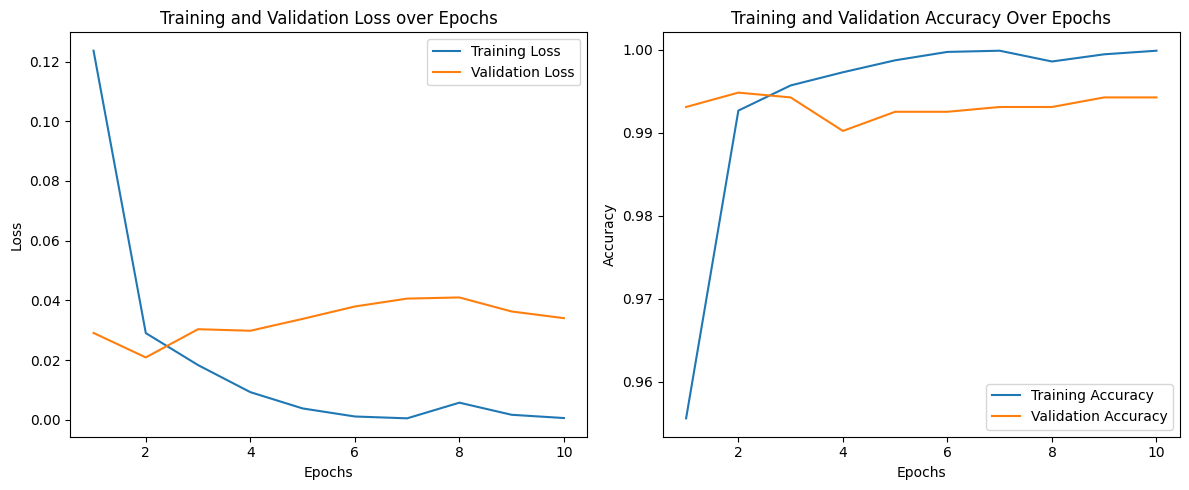

[Training]: 100%|██████████| 8670/8670 [06:50<00:00, 21.69it/s, Training loss=0.0002, Training accuracy=0.9999]

In [ ]:
# Plotting training loss and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1,num_epochs +1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label ='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

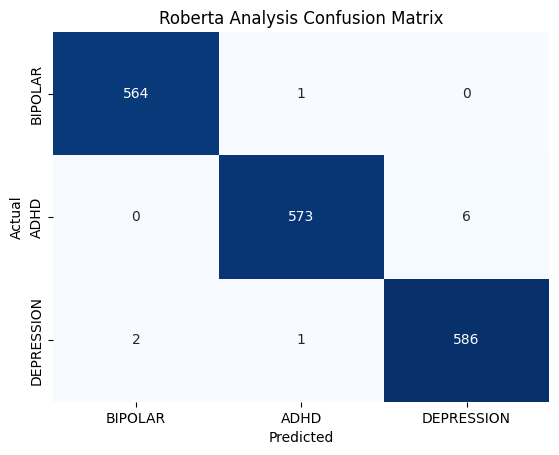

              precision    recall  f1-score   support

     BIPOLAR       1.00      1.00      1.00       565
        ADHD       1.00      0.99      0.99       579
  DEPRESSION       0.99      0.99      0.99       589

    accuracy                           0.99      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       0.99      0.99      0.99      1733



In [21]:
# Evaluation
# metric = evaluate.load("accuracy")
model.eval()

all_predictions = []
all_labels = []

for batch in eval_dataloader:
    batch = {k: v.to(device) for k,v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(batch["labels"].cpu().numpy())

    # metric.add_batch(predictions=predictions, References=batch["labels"])

# results = metric.compute()
# print("Evaluation Results:", results)

conf_matrix = confusion_matrix(all_labels, all_predictions)
# labels=["ADHD", "BIPO", "DEP"]
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', cbar=False)
ax.xaxis.set_ticklabels(unique_labels)
ax.yaxis.set_ticklabels(unique_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Roberta Analysis Confusion Matrix')
plt.show()

print(classification_report(all_labels, all_predictions, target_names=unique_labels))